# Train With Colbert

In [1]:
import os
import glob
import polars as pl
import polars.selectors as cs
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dataclasses import dataclass
from typing import Optional, Union
from scipy.special import softmax
from pathlib import Path

from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries
from colbert import Indexer, Searcher

import wandb
import torch
import evaluate
from transformers import AutoTokenizer, AutoModelForMultipleChoice, Trainer, TrainingArguments, IntervalStrategy, get_linear_schedule_with_warmup
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from datasets import Dataset # HuggingFace
from torch.optim import AdamW

In [2]:
pl.Config(fmt_str_lengths=2000);

In [3]:
#!conda install -c conda-forge faiss-gpu -y

In [4]:
dfs = []
folder_path = './data/daniel_train/aug_30/*'
columns = ['question', 'correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4', 'title', 'section_title']

for csv_file in glob.glob(folder_path):
    df = pl.read_csv(csv_file)
    dfs.append(df[columns])

train_raw = pl.concat(dfs)
train_raw.shape

(2450, 8)

In [5]:
# train_raw.write_parquet('./data/daniel_train/science_aug_30_train.parquet')

In [6]:
choices_np = train_raw[['correct', 'incorrect_1', 'incorrect_2', 'incorrect_3', 'incorrect_4']].to_numpy()

n_rows, n_cols = choices_np.shape
shuffled_indices = np.array([np.random.permutation(n_cols) for _ in range(n_rows)])
shuffled_data = np.take_along_axis(choices_np, shuffled_indices, axis=1)
correct_positions = np.argmax(shuffled_data == choices_np[:, 0][:, np.newaxis], axis=1)

answer_map = np.array(['A', 'B', 'C', 'D', 'E'])
answers = answer_map[correct_positions]

choices = pl.DataFrame({
    'A': shuffled_data[:, 0].astype(str),
    'B': shuffled_data[:, 1].astype(str),
    'C': shuffled_data[:, 2].astype(str),
    'D': shuffled_data[:, 3].astype(str),
    'E': shuffled_data[:, 4].astype(str),
    'answer': answers
    },
    [(col, pl.Utf8) for col in ['A', 'B', 'C', 'D', 'E', 'answer']]
)

train = train_raw[['question','title', 'section_title']].with_columns(choices)
train.columns

['question', 'title', 'section_title', 'A', 'B', 'C', 'D', 'E', 'answer']

In [7]:
train_osmu = pl.read_csv('./data/6000_wiki_en_sci_questions_with_excerpts.csv')
train_osmu = train_osmu.rename({'prompt': 'question'})
train_osmu.shape, train_osmu.columns

((6020, 8),
 ['question', 'A', 'C', 'B', 'D', 'E', 'answer', 'wikipedia_excerpt'])

In [8]:
test = pl.read_csv('data/train.csv')
test = test.rename({'prompt': 'question'})
test = test.drop(columns="id")
test.columns

['question', 'A', 'B', 'C', 'D', 'E', 'answer']

## Retrieve Wiki Context via ColBERT

In [9]:
max_words = 100
wiki_passages = pl.read_parquet(f'./data/wiki_passages_{max_words}.parquet')
wiki_passages.columns

['passage_id', 'section_id', 'title', 'section_title', 'passage_text']

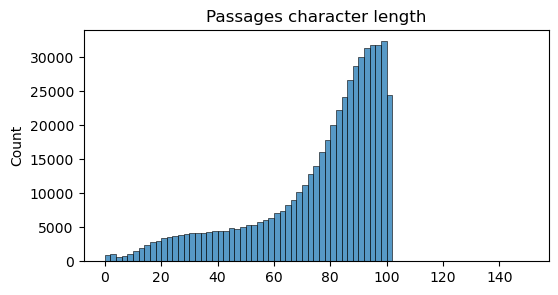

In [10]:
plt.figure(figsize=[6,3])
sns.histplot(wiki_passages['passage_text'].str.split(' ').list.lengths(), binrange=[0, 150], bins=75)
plt.title('Passages character length');

In [11]:
n_results_per_question = 3

nbits = 2   # encode each dimension with 2 bits
doc_maxlen = 512   # lenght in tokens
dim = 128 # 128 is max for BERT

wiki_passages = pl.read_parquet(f'./data/wiki_passages_{max_words}.parquet')
wiki_passages.columns

checkpoint = './checkpoints/colbertv2.0'
experiment = 'wiki-science'
indexer_name = f"wiki_pages_index_{nbits}bits_max_words{max_words}"
#os.environ['COLBERT_LOAD_TORCH_EXTENSION_VERBOSE'] = 'True'

config = ColBERTConfig(
    doc_maxlen=doc_maxlen,
    nbits=nbits,
    dim=dim
)

In [12]:
def add_wiki_context(data):
    queries = data.with_row_count('qid')[['qid', 'question']]
    queries = queries.with_columns(pl.col('question').str.replace_all('\n', ' ')) 
    queries_file = './data/wiki_queries.tsv'
    queries.write_csv(queries_file, separator='\t', has_header=False)

    c_queries = Queries(queries_file)

    with Run().context(RunConfig(nranks=1, experiment=experiment)):
        searcher = Searcher(index=indexer_name, config=config)
        ranking = searcher.search_all(c_queries, k=n_results_per_question)

    colbert_passage_ids = pl.DataFrame(pd.DataFrame(ranking.items()))
    colbert_passage_ids = colbert_passage_ids \
        .lazy() \
        .select([
            pl.col("1").list.get(0).list.get(0).alias("wiki_ctx_1").cast(pl.UInt32),
            pl.col("1").list.get(1).list.get(0).alias("wiki_ctx_2").cast(pl.UInt32),
            pl.col("1").list.get(2).list.get(0).alias("wiki_ctx_3").cast(pl.UInt32),
        ]) \
        .collect()
    
    passages = wiki_passages[['passage_id', 'passage_text']]
    data_p = data.with_columns(colbert_passage_ids)
    data_p = data_p.join(passages, how='left', left_on='wiki_ctx_1', right_on='passage_id', validate='m:1')
    data_p = data_p.join(passages, how='left', left_on='wiki_ctx_2', right_on='passage_id', validate='m:1', suffix='_2')
    return data_p.join(passages, how='left', left_on='wiki_ctx_3', right_on='passage_id', validate='m:1', suffix='_3')

In [35]:
train_p_path = Path(f'./data/train_daniel_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')
train_p_osmu_path = Path(f'./data/train_osmu_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')
test_p_path = Path(f'./data/test_daniel_with_wiki_context_{nbits}bits_max_words{max_words}.parquet')

def cached_add_wiki_context(data, cache_path):
    if cache_path.exists():
        return pl.read_parquet(cache_path)
    else:
        with_context = add_wiki_context(data)
        torch.cuda.empty_cache()
        with_context.write_parquet(cache_path)
        return with_context
    
train_p = cached_add_wiki_context(train, train_p_path)
train_p_osmu = cached_add_wiki_context(train_osmu, train_p_osmu_path)
test_p = cached_add_wiki_context(test, test_p_path)

In [36]:
train_p['passage_text'].str.split(' ').list.lengths().max()

100

## Prepare Train and Test for DeBERTa

In [37]:
deberta_v3_large = 'microsoft/deberta-v3-large'
tokenizer = AutoTokenizer.from_pretrained(deberta_v3_large)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/daniel/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
max_length = 600

option_to_index = {option: idx for idx, option in enumerate('ABCDE')}
index_to_option = {v: k for k,v in option_to_index.items()}

def preprocess(example):
    # adding the wikipedia page as context for the question by adding it after a [SEP] token to the question.
    first_sentence = [f"""{example['question']}
[SEP]{example['passage_text']}
[SEP]{example['passage_text_2']}
[SEP]{example['passage_text_3']}"""] * 5
    second_sentences = [example[option] for option in 'ABCDE']
    tokenized_example = tokenizer(first_sentence, second_sentences, truncation='only_first', max_length=max_length)
    tokenized_example['label'] = option_to_index[example['answer']]
    
    return tokenized_example

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None

    
    def __call__(self, input_batch):
        # input_batch is list of samples, choices, tokens
        additional_cols = set(input_batch[0].keys()) - set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])
        if len(additional_cols) > 0:
            print(f'{additional_cols=}')
        
        label_name = 'label' if 'label' in input_batch[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in input_batch]
        batch_size = len(input_batch)
        num_choices = len(input_batch[0]['input_ids'])
        flattened_input = [
            [{k: v[i] for k, v in sample.items()} for i in range(num_choices)] for sample in input_batch
        ]
        flattened_input = sum(flattened_input, [])
        
        batch = self.tokenizer.pad(
            flattened_input,
            padding=self.padding,
            max_length=self.max_length,
            return_tensors='pt',
        )
        
        # batch.shape = (n_samples, n_choices, n_tokens)
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        #print(np.array(batch['input_ids']).shape)
        return batch

In [39]:
columns_to_keep = set(['input_ids', 'token_type_ids', 'attention_mask', 'label'])

def tokenized_dataset(data):
    dataset = Dataset.from_pandas(data.to_pandas(), preserve_index=False)
    col_to_remove = set(dataset.map(preprocess).features.keys()) - columns_to_keep
    tokenized = dataset.map(preprocess, remove_columns=col_to_remove)
    return tokenized

In [40]:
tokenized_train = tokenized_dataset(train_p)
tokenized_train_osmu = tokenized_dataset(train_p_osmu)
tokenized_test = tokenized_dataset(test_p)

Map:   0%|          | 0/2150 [00:00<?, ? examples/s]

Map:   0%|          | 0/2150 [00:00<?, ? examples/s]

Map:   0%|          | 0/2150 [00:00<?, ? examples/s]

Map:   0%|          | 0/2150 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

<Axes: >

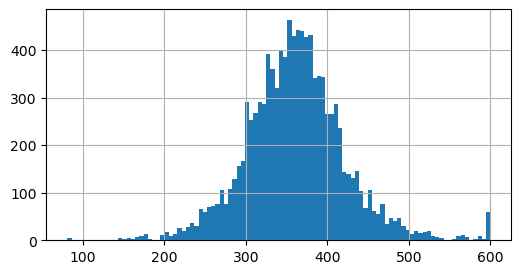

In [41]:
length_list = []
for sample in tokenized_train['input_ids']:
    for option in sample:
        length_list.append(len(option))

plt.figure(figsize=[6,3])
pd.Series(length_list).hist(bins=100)

## Train DeBERTa

In [42]:
def precision_at_k(predictions, actuals, k=3):        
    if isinstance(actuals, list):
        actuals = np.array(actuals)
        
    found_at = np.where(predictions == actuals.reshape(-1, 1))
    # found_at is a tuple with the array of found indices in the second position
    score = 1 / (1 + found_at[1])
    score[score < 1/k] = 0
    return score

def mean_avg_precision_at_k(predictions, actual, k=3):
    n = predictions.shape[0]
    row_precision = precision_at_k(predictions, actual)
    return row_precision.sum()/n

acc_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.flip(predictions.argsort(axis=1), axis=1)
    accuracy = acc_metric.compute(predictions=predictions[:,0], references=labels)['accuracy']
    map_at_3 = mean_avg_precision_at_k(predictions, labels)
    return {
        'accuracy': accuracy,
        'map_at_3': round(map_at_3, 3)
    }

In [43]:
retrain = False

output_path = Path('./checkpoints')
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=2,
    #fp16=True,
    warmup_ratio=0.5,
    weight_decay=0.0,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=16,
    evaluation_strategy = IntervalStrategy.STEPS,
    logging_steps=100,
    eval_steps=500,
    save_steps=5000,
    report_to='wandb',
    output_dir=str(output_path),
    run_name='train_with_colbert'
)

if not output_path.exists() or retrain:
    model = AutoModelForMultipleChoice.from_pretrained(deberta_v3_large)
    
    # embedding_lr = 1e-8
    # early_layers_lr = 1e-7
    # middle_layers_lr = 1e-6
    # late_layers_lr = 2e-5
    # classifier_lr = 5e-5

#     optimizer_grouped_parameters = [
#         {'params': model.deberta.embeddings.parameters(), 'lr': embedding_lr},
#         {'params': model.deberta.encoder.layer[:8].parameters(), 'lr': early_layers_lr},
#         {'params': model.deberta.encoder.layer[8:16].parameters(), 'lr': middle_layers_lr},
#         {'params': model.deberta.encoder.layer[16:].parameters(), 'lr': late_layers_lr},
#         {'params': model.classifier.parameters(), 'lr': classifier_lr},
#     ]
    optimizer = AdamW(model.parameters(),
                      lr=training_args.learning_rate,
                      weight_decay=training_args.weight_decay)
                      #optimizer_grouped_parameters)
    
    total_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
    warmup_steps = int(total_steps * training_args.warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler)
    )

    trainer.train()
    wandb.finish()
    trainer.save_model(output_path/training_args.run_name)
else:
    model = AutoModelForMultipleChoice.from_pretrained(output_path/training_args.run_name)

In [50]:
trainer = Trainer(
    model=model,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer, max_length=600),
)
test_logits = trainer.predict(tokenized_test).predictions

In [86]:
test_preds = np.argsort(-test_logits, 1)
test_letters = np.array(list('ABCDE'))[test_preds]
test_letters = pl.Series(test_letters[:,:3]).list.join(' ')
test_output = pl.DataFrame({'prediction':test_letters}).with_row_count('id')
test_output[:3]

id,prediction
u32,str
0,"""D E C"""
1,"""B D A"""
2,"""D B C"""


In [89]:
# test_output.write_csv('./data/test_predictions.csv')

In [ ]:
submission.csv